In [2]:
!pip install torchinfo --quiet
import torch
import torch.nn as nn
import numpy as np
import copy, sys, os, pickle
import requests
from io import BytesIO

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchinfo import summary
from torch import optim
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



## Load data

In [3]:
mnist_data = datasets.MNIST(root="./", download=True, transform=transforms.ToTensor())
mnist_trainset, mnist_testset = train_test_split(mnist_data, test_size=0.1, random_state=42)

train_loader_mnist = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
testloader_mnist = torch.utils.data.DataLoader(mnist_testset, batch_size=1000, shuffle=False)
n_classes = 10

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 51336024.18it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 3093984.82it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14489125.44it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11752331.13it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:

def download_file(id):
  response = requests.get(id)
  with BytesIO(response.content) as file:
    return pickle.load(file)

dropbox_url = 'https://www.dropbox.com/scl/fi/zagdv3cdcdpovq7q7f2qy/train_cifar.pickle?rlkey=l9vnwmqdcflqco9dy9pjgmw2v&st=kypisxmq&raw=1'
train_files_download = download_file(dropbox_url)
dropbox_url = 'https://www.dropbox.com/scl/fi/g6i500yd1ma8hkheirev9/test_cifar.pickle?rlkey=toj5pf2g9u87bcllzihv4j5ov&st=xm5kspi1&raw=1'
test_files_download = download_file(dropbox_url)

train_files = train_files_download['data']
label_list = train_files_download['labels']
val_files = test_files_download['data']
val_list = test_files_download['labels']

## MNIST digits classification - Simple convnet

MNIST digits - Load a sample 7

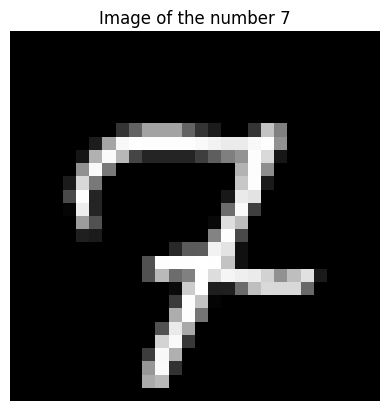

In [5]:
image_sample_7 , label_sample = mnist_trainset[next((i for i, (image, label) in enumerate(mnist_trainset) if label == 7), None)]

# Convert tensor to numpy array and plot the image
plt.imshow(image_sample_7.squeeze().numpy(), cmap='gray')
plt.title('Image of the number 7')
plt.axis('off')
plt.show()

Define model

In [6]:
class MyCNN2(nn.Module):        # The model is defined by defining the class
    def __init__(self, n_classes):
        super(MyCNN2, self).__init__()
        self.layers = nn.Sequential(
            #  (𝑁 batch size,𝐶in,𝐻,𝑊)
            nn.Conv2d(in_channels= 1, out_channels = 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features = 7*7*32, out_features = n_classes)
        )

    def forward(self, x):
        return self.layers(x)


Train model

In [7]:
model_s = MyCNN2(n_classes)        # model is an intance of the class
alpha_s, n_epochs_s = 1e-2, 3
# Loss and optimizer
criterion_s = nn.CrossEntropyLoss()
optimizer_s = torch.optim.Adam(model_s.parameters(), lr = alpha_s)

# Train the model
for epoch in range(n_epochs_s):
    for images, labels_s in train_loader_mnist:
        outputs_s = model_s(images)
        #loss = F.cross_entropy(outputs, labels)
        loss_s = criterion_s(outputs_s, labels_s)
        optimizer_s.zero_grad()
        loss_s.backward()
        optimizer_s.step()
    print(f'Epoch [{epoch+1}/{n_epochs_s}], Loss: {round(loss_s.item(), 4)}')

Epoch [1/3], Loss: 0.093
Epoch [2/3], Loss: 0.0122
Epoch [3/3], Loss: 0.1269


In [8]:
model_s.eval()
with torch.no_grad():
    output_s = model_s(image_sample_7.unsqueeze(0)) # Adds a new dimension of size 1 at specified position
    _, predicted = torch.max(output_s, 1)
predicted

tensor([7])

## Display NN layers

In [9]:
summary(model_s, input_data=torch.zeros((5, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
MyCNN2                                   [5, 10]                   --
├─Sequential: 1-1                        [5, 10]                   --
│    └─Conv2d: 2-1                       [5, 16, 28, 28]           416
│    └─ReLU: 2-2                         [5, 16, 28, 28]           --
│    └─MaxPool2d: 2-3                    [5, 16, 14, 14]           --
│    └─Conv2d: 2-4                       [5, 32, 14, 14]           12,832
│    └─ReLU: 2-5                         [5, 32, 14, 14]           --
│    └─MaxPool2d: 2-6                    [5, 32, 7, 7]             --
│    └─Flatten: 2-7                      [5, 1568]                 --
│    └─Linear: 2-8                       [5, 10]                   15,690
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
Total mult-adds (M): 14.28
Input size (MB): 0.02
Forward/backward pass size (MB): 0.75
Params size (MB): 0.12
Estimated Total Size (MB): 0.88

### Evaluation

We now evaluate our trained model on the test data. We first call torch.no_grad() to disable gradient computation to save memory and runtime. This is useful when we are only doing inference and do not update the model.



In [10]:
# label_list = []
# predicted_list = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader_mnist:
        outputs = model_s(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #breakpoint()
    print(f'Test Accuracy of the model on the 10000 test images: {100 * correct / total}')

Test Accuracy of the model on the 10000 test images: 97.0


### LeNet

Define model

In [11]:
class LeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        args:
            input_dim (Tuple): the shape (n_channels, height, width) of a sample data point
            output_dim (int): the number of nodes in the output layer
        """
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_dim[0], 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(1),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, output_dim))

    def forward(self, x):
        return self.layer1(x)

class AlexNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_dim[0], 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout()
            ,nn.Flatten(1)
            ,nn.Linear(1024, 4096)
            ,nn.ReLU(inplace = True)
            ,nn.Dropout()
            ,nn.Linear(4096, 1024)
            ,nn.ReLU(inplace = True)
            ,nn.Linear(1024, output_dim)
            )

    def forward(self, x):

        out = self.layer1(x)

        return out

Define training

In [12]:
def train_model(model, n_epochs, train_loader, val_loader, optimizer, scheduler = None, verbose = False, filepath=None, device='cpu'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(device)

    train_accuracy = []; train_loss = []; val_accuracy = []; val_loss = []
    best_acc = 0
    best_model_loop = 1

    for i in range(n_epochs):

        losses = []
        total = 0
        matches = 0

        model.train()                                       # Set your model to training mode

        for X, y in train_loader:                           # Iterate over all samples by minibatches
            X, y = X.to(device), y.to(device)               # Set tensors to GPU if available
            outputs = model(X)

            loss = F.cross_entropy(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #breakpoint()
            y_hat = torch.argmax(outputs, axis = 1)         # Index with highest prob = prediction

            matches = matches + ((y==y_hat).sum()).item()   # Keep count of correct matches during training
            total = total + y.size(0)                       # Keep count of total number of samples during training
            losses.append(loss.item())

        # The average training loss is defined as the sum of loss values across all minibatches, divided by the number of minibatches.
        # print(f'Average TRAINING accuracy across in epoch: {i}', (matches/total))

        # The average training accuracy is defined as the sum of correct matches across all minibatches, divided by the number of minibatches.
        train_acc=matches/total
        train_loss.append(np.mean(losses))
        train_accuracy.append(train_acc)
        print('Tr: ', round(train_acc,2), end=' ')

        # used to dynamically adjust the learning rate during training. Should be called once every epoch after all the training iterations in that epoch have finished.
        if scheduler is not None: scheduler.step()

        matches = 0
        total = 0
        model.eval()

        with torch.no_grad():
          for X, y in val_loader:
              X, y = X.to(device), y.to(device)

              outputs = model(X)
              y_hat = torch.argmax(outputs, axis = 1)

              matches = matches + ((y==y_hat).sum()).item()
              total = total + y.size(0)

          val_accuracy.append(matches/total)

          if (best_acc < matches/total):
              best_acc = matches/total
              best_model_loop = i+1
              best_model = copy.deepcopy(model)

        test_acc = matches/total
        print('Te: ', round(test_acc,2), end=' ')


    if filepath is not None:
        torch.save(best_model.state_dict(), filepath)

    return (best_model, best_model_loop, train_accuracy, train_loss, val_accuracy)



Load Dataset and DataLoader

In [13]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):

    def __init__(self, data_dict, label_list):
        # self.data is a container for the dataset, which should be a 4D Numpy array of shape (n_images, height, width, n_channels).
        self.data = data_dict.reshape(-1, 32, 32, 3)
        self.labels = label_list

    def __len__(self): return(len(self.labels))

    def __getitem__(self, idx):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5),(.5,.5, .5))])

        tensor = transform(self.data[idx])
        dlabel = self.labels[idx]

        return (tensor, dlabel)

# Create a dataloader
def get_dataloader(trainset, valset = None, batch_size = 64, num_workers = 2):

    train = DataLoader(dataset = trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val = DataLoader(dataset = valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train, val


In [14]:
full_trainset = ImageDataset(train_files, label_list)
full_valset = ImageDataset(val_files, val_list)


In [15]:
input_dim, output_dim = (3, 32, 32), 10

# hyperparameters
lr = 0.001
weight_decay = 5e-4
batch_size = 128
n_epochs = 30
scheduler = None

model = AlexNet(input_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
train_loader, val_loader = get_dataloader(full_trainset, full_valset, batch_size=batch_size)

#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 * epoch)
best_model, best_acc_epoch_num, train_accs, train_losses, val_accs = train_model(model, n_epochs, train_loader, val_loader, optimizer, scheduler=scheduler, verbose = False)


cuda
Tr:  0.25 Te:  0.34 Tr:  0.4 Te:  0.46 Tr:  0.47 Te:  0.48 Tr:  0.51 Te:  0.53 Tr:  0.54 Te:  0.54 Tr:  0.57 Te:  0.55 Tr:  0.59 Te:  0.55 Tr:  0.61 Te:  0.56 Tr:  0.62 Te:  0.59 Tr:  0.64 Te:  0.58 Tr:  0.65 Te:  0.59 Tr:  0.67 Te:  0.58 Tr:  0.68 Te:  0.59 Tr:  0.69 Te:  0.59 Tr:  0.7 Te:  0.6 Tr:  0.71 Te:  0.59 Tr:  0.72 Te:  0.6 Tr:  0.73 Te:  0.6 Tr:  0.74 Te:  0.6 Tr:  0.75 Te:  0.6 Tr:  0.76 Te:  0.6 Tr:  0.77 Te:  0.6 Tr:  0.78 Te:  0.6 Tr:  0.78 Te:  0.6 Tr:  0.79 Te:  0.59 Tr:  0.8 Te:  0.58 Tr:  0.81 Te:  0.59 Tr:  0.81 Te:  0.59 Tr:  0.82 Te:  0.59 Tr:  0.82 Te:  0.58 

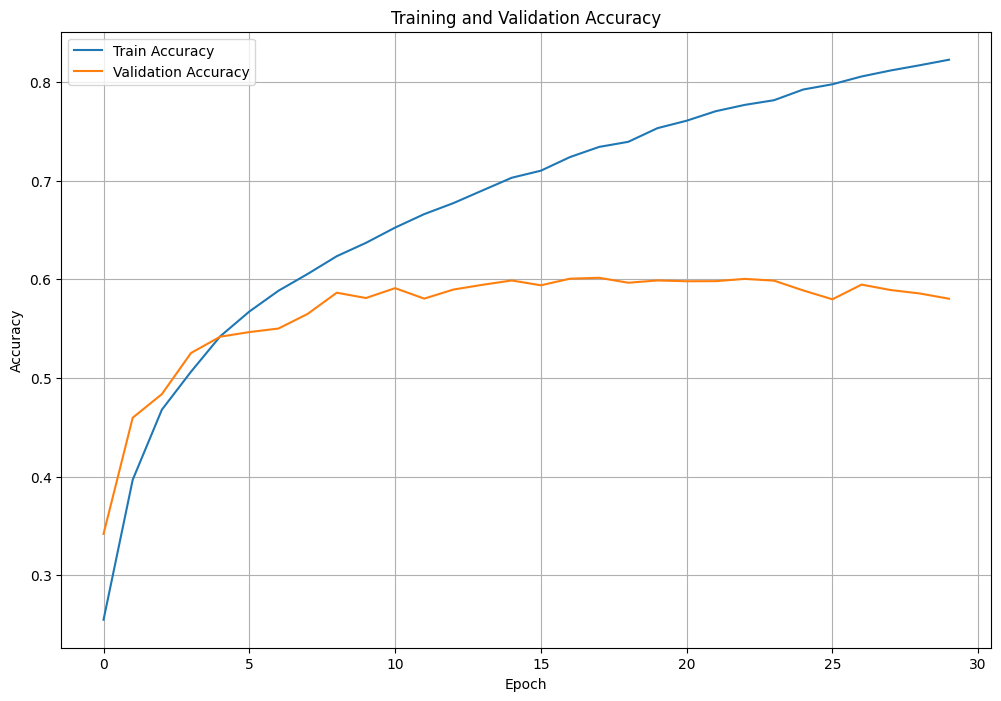

In [19]:

plt.figure(figsize=(12, 8))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Test accuracy doesnt improve after 10 epochs while it continues to increase for training suggesting overfitting.  Learning rates and weight decay can be adjusted to improve out of sample accuracy